# Libraries

In [1]:
import random
import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Synthetic Dataset

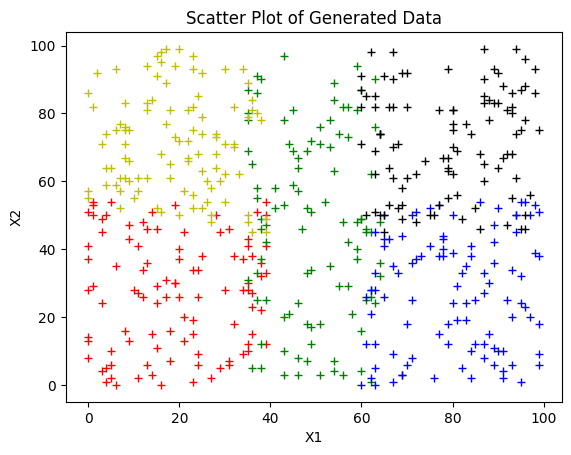

In [16]:
np.random.seed(0)
# Number of samples
n_samples = 500

# Define ranges
ranges1 = [(0, 40), (35, 65), (60, 100), (0, 40), (60, 100)]
ranges2 = [(0, 55), (0, 100), (0, 55), (45, 100), (45, 100)]

# Generate the dataset
X1 = np.concatenate([np.random.randint(r_min, r_max, size=(n_samples // 5, 1)) for r_min, r_max in ranges1])
X2 = np.concatenate([np.random.randint(r_min, r_max, size=(n_samples // 5, 1)) for r_min, r_max in ranges2])
X = np.hstack((X1, X2)) #horizontal stacking

# Generate labels
Y = np.array([i for i in range(5) for repeat in range(n_samples // 5)])

# Plotting
colors = ['r+', 'g+', 'b+', 'y+', 'k+']
for i, (x1, x2) in enumerate(X):
    plt.plot(x1, x2, colors[Y[i]])

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot of Generated Data')
plt.show()

Y = OneHotEncoder(sparse_output=False).fit_transform(Y.reshape(-1, 1)) #coverts categorical data into binary matrix

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) #Train= 80%; test=20%

# Neural Network Model

In [42]:
class NeuralNetwork(object):
    def __init__(self):
        #define neurons
        inputLayerNeurons = 2
        hiddenLayer1Neurons =8
        hiddenLayer2Neurons = 8
        hiddenLayer3Neurons = 8
        outLayerNeurons = 5
        self.learning_rate = 0.008
        #np.random.seed(3)
        #input-hidden1
        self.W_HI = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons)
        self.b_HI = np.random.randn(1, hiddenLayer1Neurons)
        #hidden1-hidden2
        self.W_HH1 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons)
        self.b_HH1 = np.random.randn(1, hiddenLayer2Neurons)
        #hidden2-hidden3
        self.W_HH2 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons)
        self.b_HH2 = np.random.randn(1, hiddenLayer3Neurons)
        #hidden3-output
        self.W_OH = np.random.randn(hiddenLayer3Neurons, outLayerNeurons)
        self.b_OH = np.random.randn(1, outLayerNeurons)

    def sigmoid(self, x, der=False):
      if der == True:
        return x * (1-x)
      else:
        return 1 / (1 + np.exp(-x))

    def relu(self, x, der=False):
        if der:
            return np.where(x > 0, 1, 0)
        else:
            return np.maximum(0, x)

    def softmax(self, x, der=False):
      if der:
        for i in range(len(x)):
          jacobian_mat = np.diagflat(x[i]) - np.outer(x[i], x[i])
          x[i] = np.max(np.abs(jacobian_mat), axis=1)
        return x
      else:
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feedForward(self, X):
        hidden_input1 = np.dot(X, self.W_HI) + self.b_HI
        self.hidden_output1 = self.sigmoid(hidden_input1)

        hidden_input2 = np.dot(self.hidden_output1, self.W_HH1) + self.b_HH1
        self.hidden_output2 = self.sigmoid(hidden_input2)

        hidden_input3 = np.dot(self.hidden_output2, self.W_HH2) + self.b_HH2
        self.hidden_output3 = self.sigmoid(hidden_input3)

        output_input = np.dot(self.hidden_output3, self.W_OH) + self.b_OH
        pred = self.softmax(output_input)
        return pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred
        output_delta = self.learning_rate * output_error * self.softmax(pred, der=True)

        hidden_error3 = output_delta.dot(self.W_OH.T)
        hidden_delta3 = self.learning_rate * hidden_error3 * self.sigmoid(self.hidden_output3, der=True)

        hidden_error2 = hidden_delta3.dot(self.W_HH2.T)
        hidden_delta2 = self.learning_rate * hidden_error2 * self.sigmoid(self.hidden_output2, der=True)

        hidden_error1 = hidden_delta2.dot(self.W_HH1.T)
        hidden_delta1 = self.learning_rate * hidden_error1 * self.sigmoid(self.hidden_output1, der=True)

        self.W_HI += X.T.dot(hidden_delta1)
        self.b_HI += np.sum(hidden_delta1, axis=0, keepdims=True)

        self.W_HH1 += self.hidden_output1.T.dot(hidden_delta2)
        self.b_HH1 += np.sum(hidden_delta2, axis=0, keepdims=True)

        self.W_HH2 += self.hidden_output2.T.dot(hidden_delta3)
        self.b_HH2 += np.sum(hidden_delta3, axis=0, keepdims=True)

        self.W_OH += self.hidden_output3.T.dot(output_delta)
        self.b_OH += np.sum(output_delta, axis=0, keepdims=True)

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X,Y,output)

# Model Training

100%|██████████| 2000/2000 [00:22<00:00, 89.41it/s] 


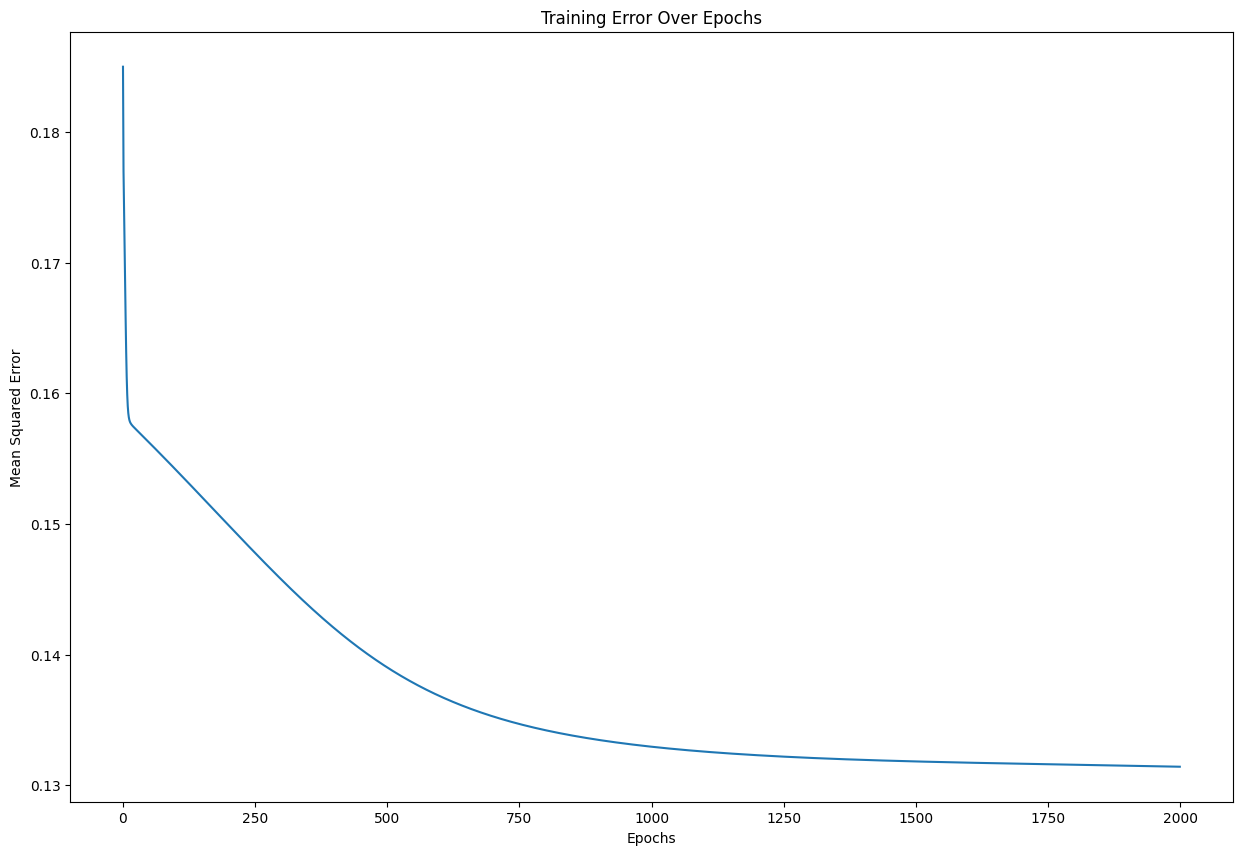

In [43]:
NN = NeuralNetwork()
err = []
for i in tqdm.tqdm(range(2000)):
  NN.train(X_train,Y_train)
  err.append(np.mean(np.square(Y - NN.feedForward(X))))

plt.figure(figsize=(15,10))
plt.plot(err)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training Error Over Epochs')
plt.show()

# Model Evaluation

In [44]:
pred_probs = NN.feedForward(X_test)
predictions = np.argmax(pred_probs, axis=1)
actual = np.argmax(Y_test, axis=1)

#classification report
print("Classification Report:")
print(classification_report(actual, predictions, target_names=[f'Class {i}' for i in range(5)], zero_division=0))

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.12      0.04      0.06        28
     Class 1       0.00      0.00      0.00        14
     Class 2       0.26      0.50      0.34        10
     Class 3       0.61      0.71      0.65        24
     Class 4       0.53      1.00      0.70        24

    accuracy                           0.47       100
   macro avg       0.31      0.45      0.35       100
weighted avg       0.34      0.47      0.37       100



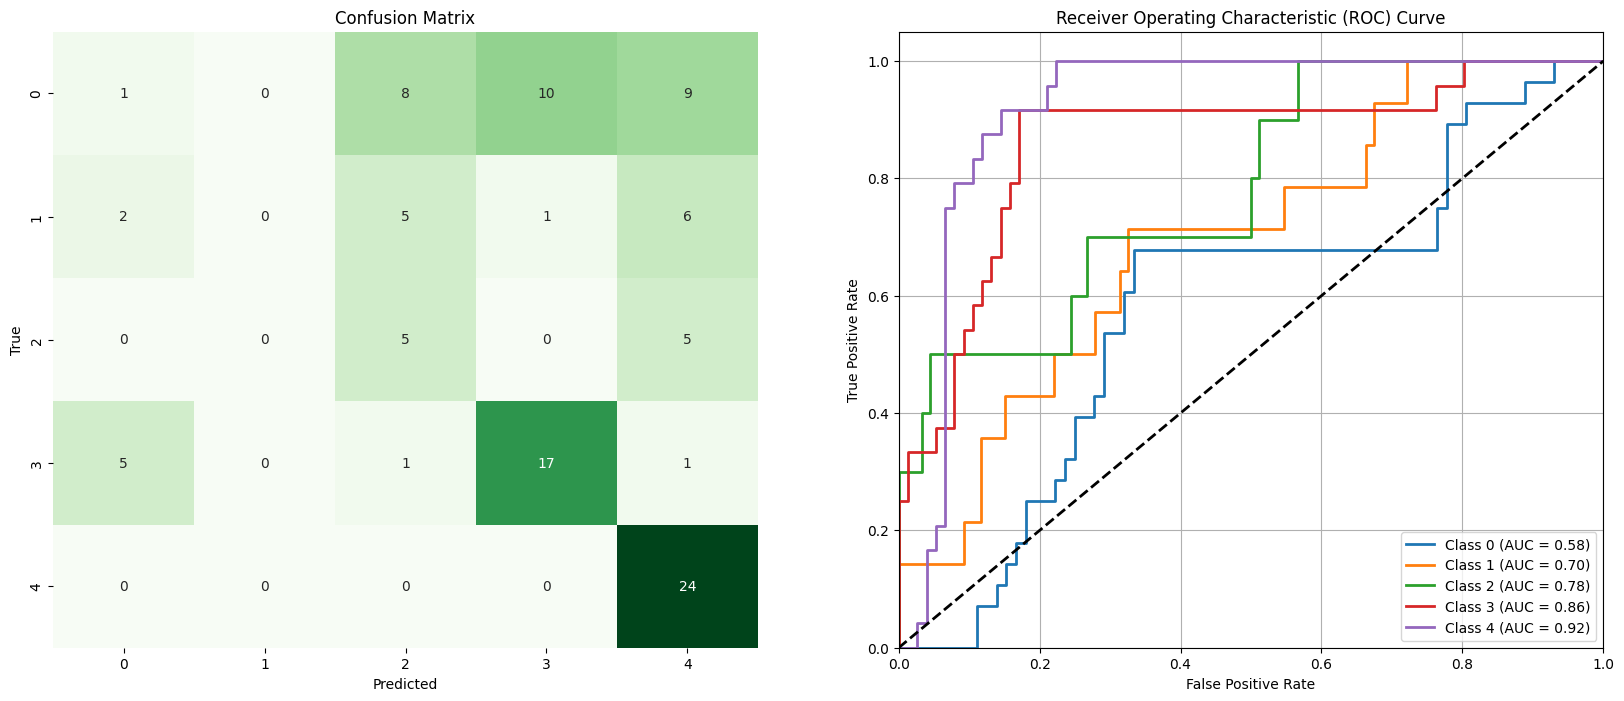

In [45]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1 )
#confusion matrix
conf_matrix = confusion_matrix(actual, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=[f'{i}' for i in range(5)],
            yticklabels=[f'{i}' for i in range(5)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.subplot(1, 2, 2)
#roc curve
for i in range(5):
    fpr, tpr, _ = roc_curve(Y_test[:, i], pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# **Documentation**
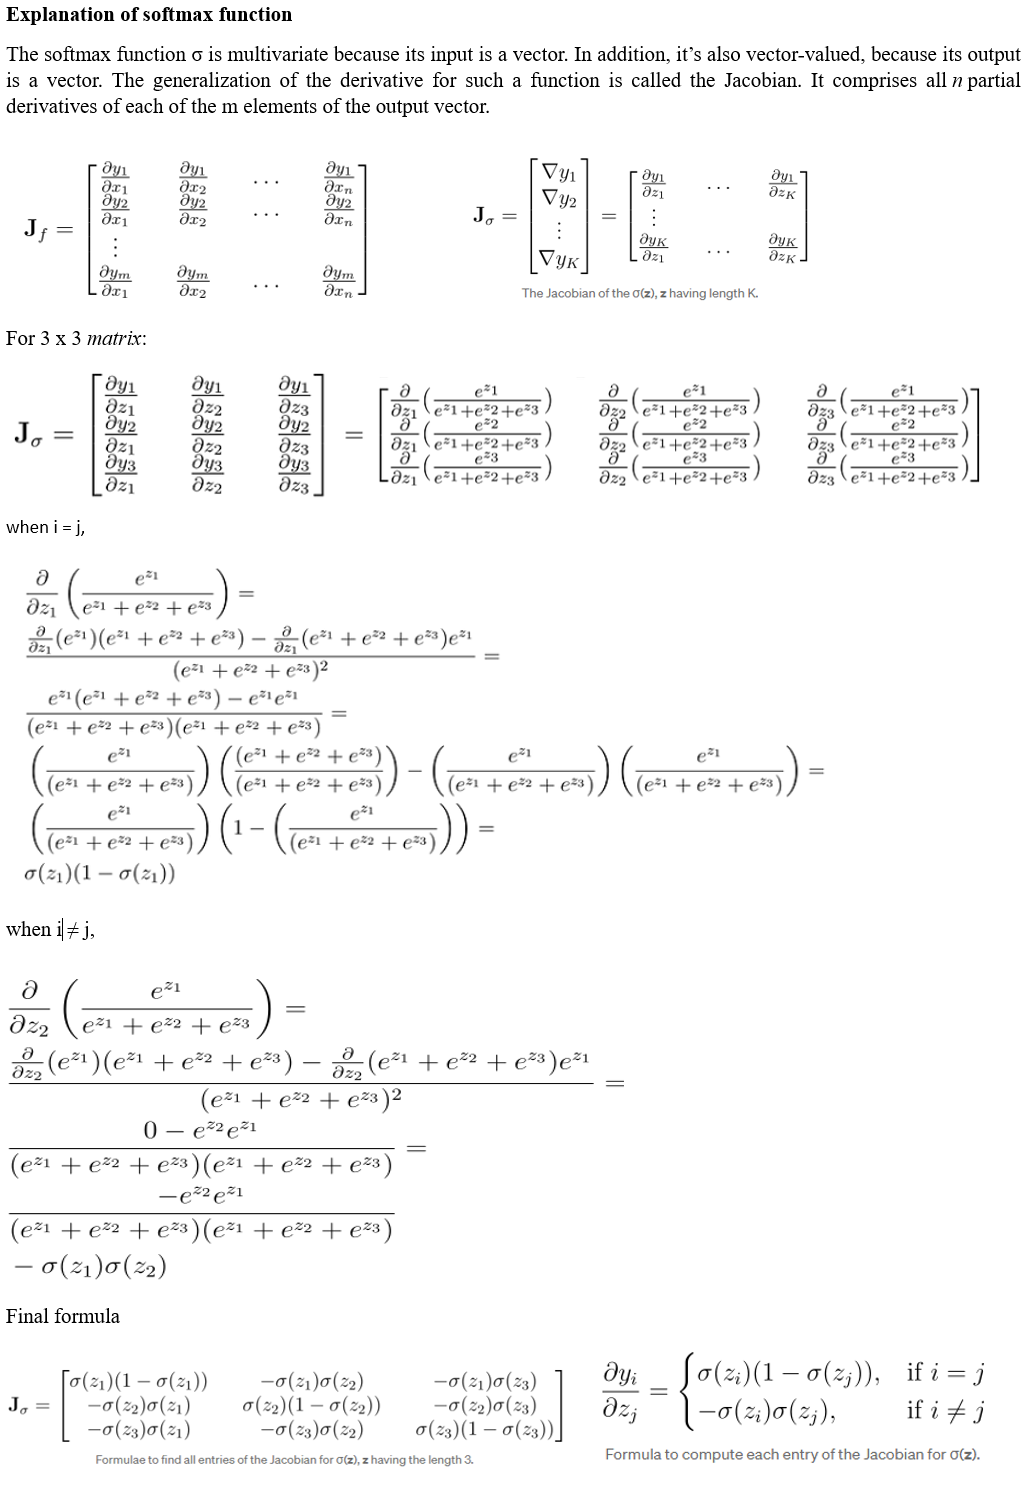

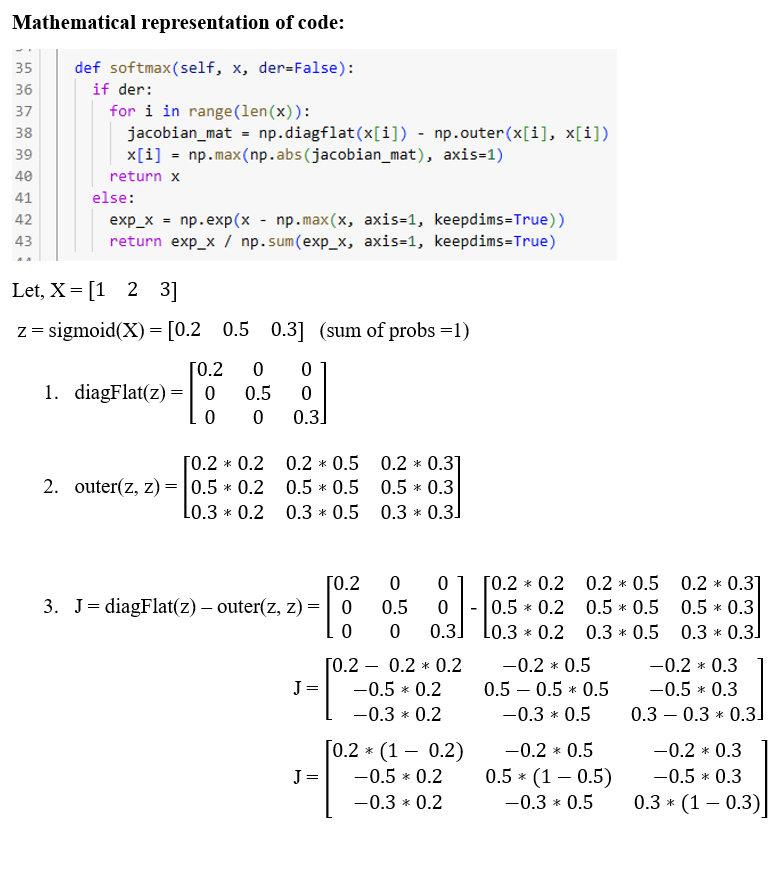

Reference: https://medium.com/@irenemarkelic/mastering-the-softmax-function-understanding-its-derivative-with-a-step-by-step-example-a5106a31581c